     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3378
           1       0.98      0.77      0.86       523

    accuracy                           0.97      3901
   macro avg       0.97      0.88      0.92      3901
weighted avg       0.97      0.97      0.96      3901



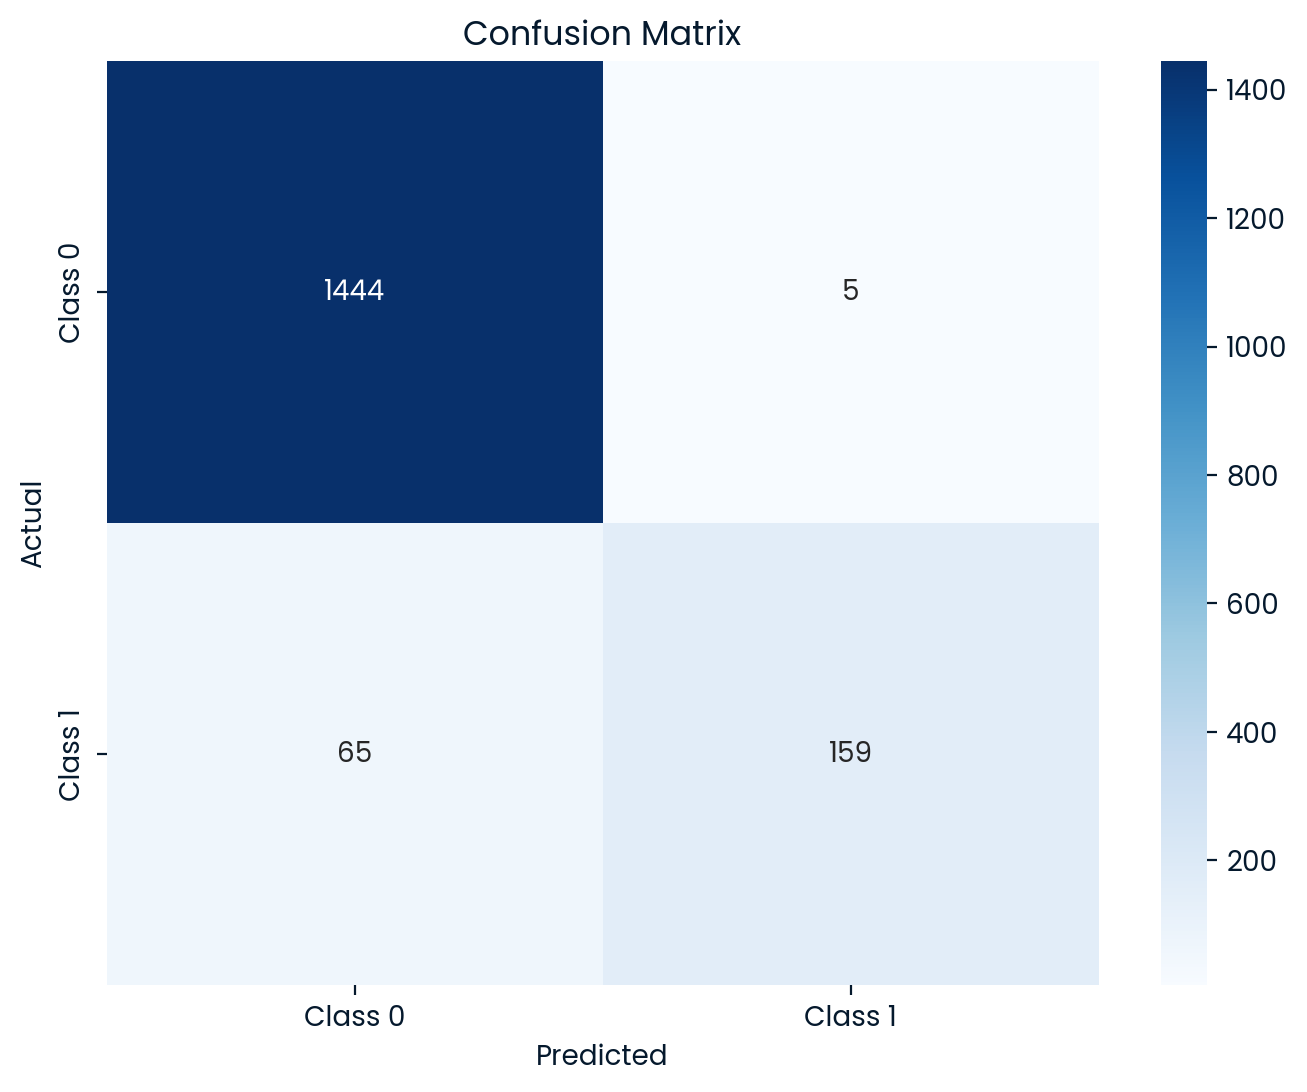

Accuracy: 0.96
Sensitivity: 0.71
Specificity: 1.00
Tekst o najwyższym prawdopodobieństwie klasy 0: Ok Ill right later (Prawdopodobieństwo: 1.00)
Tekst o najwyższym prawdopodobieństwie klasy 1: URGENT Mobile number awarded prize GUARANTEED Call land line Claim Valid hrs ppm (Prawdopodobieństwo: 0.96)
Prawdopodobieństwo klasy 1 dla podanego tekstu: 0.04


In [37]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
import pandas as pd
import re


################################################ zadanie 8 #######################################################


# 1. Wczytanie pliku CSV
# Ustawiamy separator na średnik i brak nagłówka
df = dd.read_csv('sms.csv', sep=';', header=None, names=['id', 'text', 'label'])

# 2. Podział na zbiór treningowy i testowy
train_df, test_df = train_test_split(df.compute(), test_size=0.3, stratify=df['label'].compute(), random_state=42)

# 3. Usunięcie interpunkcji i cyfr
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'\d+', '', x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'\d+', '', x))

# 4. Usunięcie stopwords
with open('stopwords.txt', 'r') as file:
    stopwords = set(file.read().splitlines())

train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))

# 5. Tokenizacja i hashing trick
vectorizer = HashingVectorizer(n_features=10000)
X_train = vectorizer.transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Konwersja do DataFrame dla podglądu
X_train_df = pd.DataFrame(X_train.toarray())

# Wyświetlenie podglądu pierwszych 5 wierszy i pierwszych 5 kolumn zbioru treningowego
print(X_train_df.iloc[:5, :5])

################################################ zadanie 9 #######################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Przygotowanie danych
X_train = vectorizer.transform(train_df['text'])
y_train = train_df['label']

# 2. Budowa modelu regresji logistycznej
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 3. Ocena modelu na zbiorze treningowym
train_predictions = model.predict(X_train)
print(classification_report(y_train, train_predictions))
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns

################################################ zadanie 10 #######################################################

# 1. Przygotowanie danych testowych
X_test = vectorizer.transform(test_df['text'])
y_test = test_df['label']

# 2. Predykcje na zbiorze testowym
test_predictions = model.predict(X_test)

# 3. Macierz pomyłek
cm = confusion_matrix(y_test, test_predictions)

# 4. Obliczenie metryk
accuracy = accuracy_score(y_test, test_predictions)
sensitivity = recall_score(y_test, test_predictions, pos_label=1)
specificity = recall_score(y_test, test_predictions, pos_label=0)

# 5. Wyświetlenie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 6. Wyświetlenie metryk
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

####################################################### zadanie 11 #######################################################

# 1. Obliczenie prawdopodobieństw przynależności do klasy 0/1 dla tekstów zbioru testowego
probabilities = model.predict_proba(X_test)

# 2. Tekst o najwyższym szacowanym prawdopodobieństwie przypisania do klasy 0
max_prob_class_0_index = probabilities[:, 0].argmax()
max_prob_class_0_text = test_df.iloc[max_prob_class_0_index]['text']
max_prob_class_0_value = probabilities[max_prob_class_0_index, 0]

# 3. Tekst o najwyższym szacowanym prawdopodobieństwie przypisania do klasy 1
max_prob_class_1_index = probabilities[:, 1].argmax()
max_prob_class_1_text = test_df.iloc[max_prob_class_1_index]['text']
max_prob_class_1_value = probabilities[max_prob_class_1_index, 1]

# 4. Prawdopodobieństwo klasy 1 (spam) dla podanego tekstu
sample_text = "How many machine learning specialists does it take to change a light bulb? - Just one, but they require a million light bulbs to train properly"
sample_text_cleaned = re.sub(r'[^\w\s]', '', sample_text)
sample_text_cleaned = re.sub(r'\d+', '', sample_text_cleaned)
sample_text_cleaned = ' '.join([word for word in sample_text_cleaned.split() if word.lower() not in stopwords])
sample_vector = vectorizer.transform([sample_text_cleaned])
sample_prob = model.predict_proba(sample_vector)[0, 1]

# Wyświetlenie wyników
print(f'Tekst o najwyższym prawdopodobieństwie klasy 0: {max_prob_class_0_text} (Prawdopodobieństwo: {max_prob_class_0_value:.2f})')
print(f'Tekst o najwyższym prawdopodobieństwie klasy 1: {max_prob_class_1_text} (Prawdopodobieństwo: {max_prob_class_1_value:.2f})')
print(f'Prawdopodobieństwo klasy 1 dla podanego tekstu: {sample_prob:.2f}')

Pierwsze 10 wierszy:
   id                                               text  label
0   1                  Sorry, I'll call later in meeting      0
1   2                     Dont worry. I guess he's busy.      0
2   3                  Call FREEPHONE 0800 542 0578 now!      1
3   4        Win a 1000 cash prize or a prize worth 5000      1
4   5  Go until jurong point, crazy.. Available only ...      0
5   6                      Ok lar... Joking wif u oni...      0
6   7  Free entry in 2 a wkly comp to win FA Cup fina...      1
7   8  U dun say so early hor... U c already then say...      0
8   9  Nah I don't think he goes to usf, he lives aro...      0
9  10  FreeMsg Hey there darling it's been 3 week's n...      1

Liczba wszystkich wierszy: 5574

Procent przykładów z klas 0 i 1:
label
0    86.598493
1    13.401507
Name: proportion, dtype: float64

Najkrótszy tekst ma 2 znaków.
Najdłuższy tekst ma 910 znaków.
Średnia długość tekstu: 79.74 znaków.


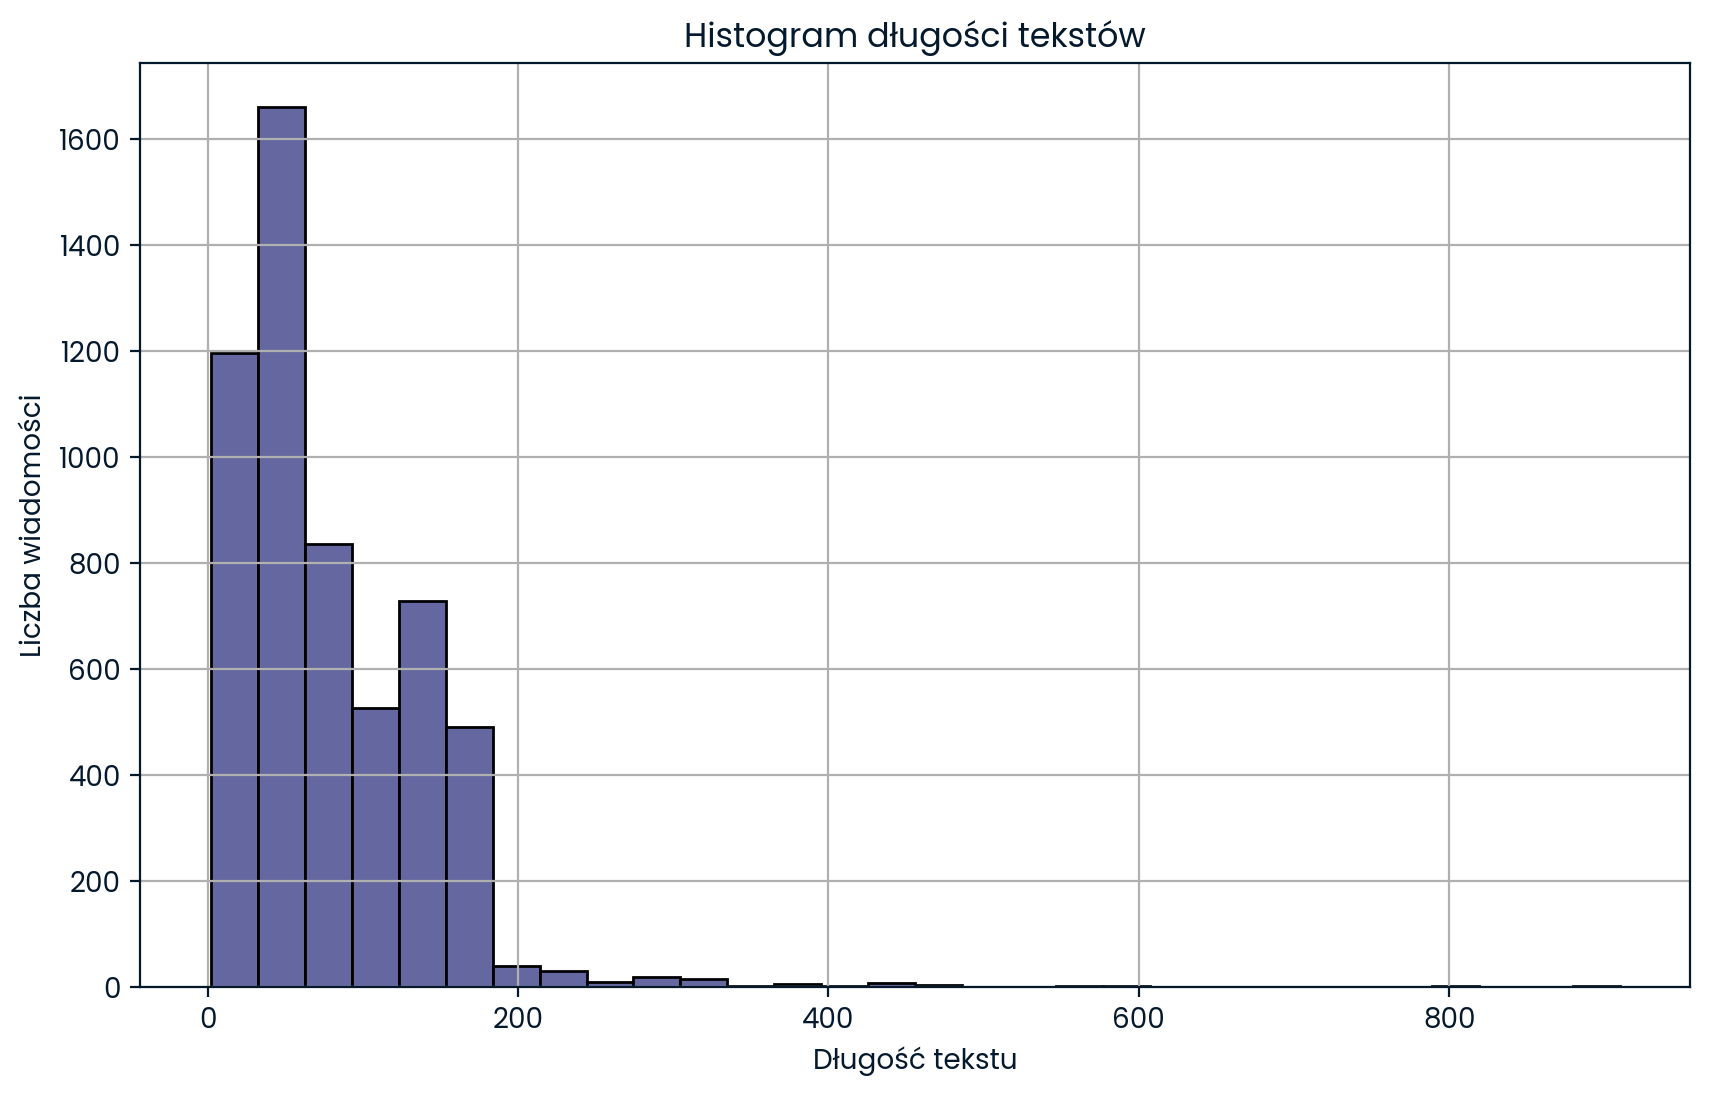

In [35]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# 1. Wczytanie pliku CSV
# Ustawiamy separator na średnik i brak nagłówka
df = dd.read_csv('sms.csv', sep=';', header=None, names=['id', 'text', 'label'])

# 2. Wyświetl podgląd 10 pierwszych wierszy
print("Pierwsze 10 wierszy:")
print(df.head(10))

# 3. Statystyki:

# a) Liczba wszystkich wierszy
total_rows = df.shape[0].compute()
print(f"\nLiczba wszystkich wierszy: {total_rows}")

# b) Procent przykładów z klas 0 i 1
label_counts = df['label'].value_counts(normalize=True).compute() * 100
print("\nProcent przykładów z klas 0 i 1:")
print(label_counts)

# c) Długość najkrótszego i najdłuższego tekstu, średnia długość tekstu
# Najpierw dodajmy nową kolumnę z długością tekstu
df['text_length'] = df['text'].str.len()

min_length = df['text_length'].min().compute()
max_length = df['text_length'].max().compute()
avg_length = df['text_length'].mean().compute()

print(f"\nNajkrótszy tekst ma {min_length} znaków.")
print(f"Najdłuższy tekst ma {max_length} znaków.")
print(f"Średnia długość tekstu: {avg_length:.2f} znaków.")

# 4. Histogram długości tekstów

# Ponieważ Dask nie rysuje wykresów bezpośrednio, musimy przekonwertować na pandas
lengths = df['text_length'].compute()

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title("Histogram długości tekstów")
plt.xlabel("Długość tekstu")
plt.ylabel("Liczba wiadomości")
plt.grid(True)
plt.show()
